In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()


In [31]:
# benchmarkName = "ab-main-main-2022-11-04T12:30:42+01:00"
# benchmarkName = "ab-main-perf-issue-clean-path-2022-11-05T20:39:50+01:00"
# benchmarkName = "ab-main-perf-issue-request-id-2022-11-04T14:18:47+01:00"
benchmarkName = "ab-main-perf-issue-basic-auth-2022-11-06T13:36:52+01:00"


df1 = pd.read_csv(f"../results/fbs/{benchmarkName}/v1.csv.gz")
df2 = pd.read_csv(f"../results/fbs/{benchmarkName}/v2.csv.gz")
df = pd.concat([df1, df2])
df.head(n=50)

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,iter,method,name,scenario,status,url,extra_tags
0,http_reqs,1667738298,1.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
1,http_req_duration,1667738298,24.177594,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
2,http_req_blocked,1667738298,1.829676,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
3,http_req_connecting,1667738298,1.690888,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
4,http_req_tls_handshaking,1667738298,0.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
5,http_req_sending,1667738298,0.675822,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
6,http_req_waiting,1667738298,23.336294,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
7,http_req_receiving,1667738298,0.165478,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
8,http_req_failed,1667738298,0.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1
9,http_reqs,1667738298,1.000000,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,version=v1


In [32]:
df_req_durations = df[df['metric_name'] == 'http_req_duration'].copy()

df_req_durations.rename(columns={'extra_tags': 'version', 'name': 'path'}, inplace=True)
df_req_durations['version'] = df_req_durations['version'].str.replace('version=', '')
df_req_durations['method_path'] = df_req_durations['method'] + " " + df_req_durations['path'].str[3:]
# df_req_durations['scenario_iter'] = df_req_durations['scenario'] + "_" + df_req_durations['iter'].astype(int).astype(str)
# df_req_durations.groupby(['version', 'scenario']).size()
df_req_durations


,metric_name,timestamp,metric_value,check,error,error_code,expected_response,iter,method,path,scenario,status,url,version,method_path
1,http_req_duration,1667738298,24.177594,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,v1,GET /destinations
10,http_req_duration,1667738298,45.764224,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,v1,GET /destinations
19,http_req_duration,1667738298,41.893697,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,v1,GET /destinations
28,http_req_duration,1667738298,45.944069,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,v1,GET /destinations
37,http_req_duration,1667738298,45.936450,NaN,NaN,NaN,True,0.0,GET,${}/destinations,searchFlights,200.0,http://10.132.15.202:3000/destinations,v1,GET /destinations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358202,http_req_duration,1667739526,6.061100,NaN,NaN,NaN,True,379.0,GET,${}/flights?from=${},searchAndBookFlight,200.0,http://10.132.15.202:3001/flights?from=UYY,v2,GET /flights?from=${}
2358211,http_req_duration,1667739526,1.662821,NaN,NaN,NaN,True,379.0,GET,${}/flights/${}/seats,searchAndBookFlight,200.0,http://10.132.15.202:3001/flights/e645c07c-f6e...,v2,GET /flights/${}/seats
2358222,http_req_duration,1667739527,1.385196,NaN,NaN,NaN,True,379.0,GET,${}/flights/${}/seats,searchAndBookFlight,200.0,http://10.132.15.202:3001/flights/ae6a0183-d91...,v2,GET /flights/${}/seats
2358233,http_req_duration,1667739528,4.636913,NaN,NaN,NaN,True,379.0,POST,${}/bookings,searchAndBookFlight,200.0,http://10.132.15.202:3001/bookings,v2,POST /bookings


In [33]:
# remove 120 seconds from the last ts
# maxCutoffTs = df_req_durations['timestamp'].max() - 120
# maxCutoffTs = df_req_durations['timestamp'].max() - 660
maxCutoffTs = df_req_durations['timestamp'].max() - 200

# add 60 seconds to the first ts
minCutoffTs = df_req_durations['timestamp'].min() + 60


# enforce cutoff
# therefore we need to find out the iteration for a certain timestamp
# df_filtered = df_req_durations[(df_req_durations['timestamp'] >= minCutoffTs) & (df_req_durations['timestamp'] <= maxCutoffTs)]
# df_filtered.groupby(['version', 'scenario']).size()
cutoffLo = df_req_durations[df_req_durations['timestamp'] == minCutoffTs]\
    .groupby(['scenario']).max('iter').reset_index()
cutoffHi = df_req_durations[df_req_durations['timestamp'] == maxCutoffTs]\
    .groupby(['scenario']).min('iter').reset_index()


cutoffSearchAndBookFlightMin = cutoffLo[cutoffLo['scenario'] == 'searchAndBookFlight']['iter'].iloc[0]
cutoffSearchAndBookFlightMax = cutoffHi[cutoffHi['scenario'] == 'searchAndBookFlight']['iter'].iloc[0]
print(f"cutoff(searchAndBookFlight): {cutoffSearchAndBookFlightMin} - {cutoffSearchAndBookFlightMax}")
cutoffSearchFlightsMin = cutoffLo[cutoffLo['scenario'] == 'searchFlights']['iter'].iloc[0]
cutoffSearchFlightsMax = cutoffHi[cutoffHi['scenario'] == 'searchFlights']['iter'].iloc[0]
print(f"cutoff(searchFlights): {cutoffSearchFlightsMin} - {cutoffSearchFlightsMax}")

df_filtered = df_req_durations[(
        ((df_req_durations['iter'] >= cutoffSearchAndBookFlightMin) &
         (df_req_durations['iter'] <= cutoffSearchAndBookFlightMax) &
         (df_req_durations['scenario'] == 'searchAndBookFlight')) |
        ((df_req_durations['iter'] >= cutoffSearchFlightsMin) &
         (df_req_durations['iter'] <= cutoffSearchFlightsMax) &
         (df_req_durations['scenario'] == 'searchFlights'))
)]
# now every endpoint for each version has the same amount of requests
df_filtered.groupby(['scenario', 'method_path', 'version']).size()

cutoff(searchAndBookFlight): 21.0 - 316.0
cutoff(searchFlights): 103.0 - 1701.0


scenario             method_path             version
searchAndBookFlight  GET /destinations       v1          2960
                                             v2          2960
                     GET /flights/${}/seats  v1          2960
                                             v2          2960
                     GET /flights?from=${}   v1          2960
                                             v2          2960
                     POST /bookings          v1          2960
                                             v2          2960
searchFlights        GET /destinations       v1         79950
                                             v2         79950
                     GET /flights?from=${}   v1         79950
                                             v2         79950
dtype: int64

  version  timestamp_min  timestamp_max  ts_range  ts_min_drift  ts_max_drift  \
0      v1     1667738358     1667739308       950          -2.0         -21.0   
1      v2     1667738360     1667739329       969           NaN           NaN   

   ts_range_drift  
0           -19.0  
1             NaN  


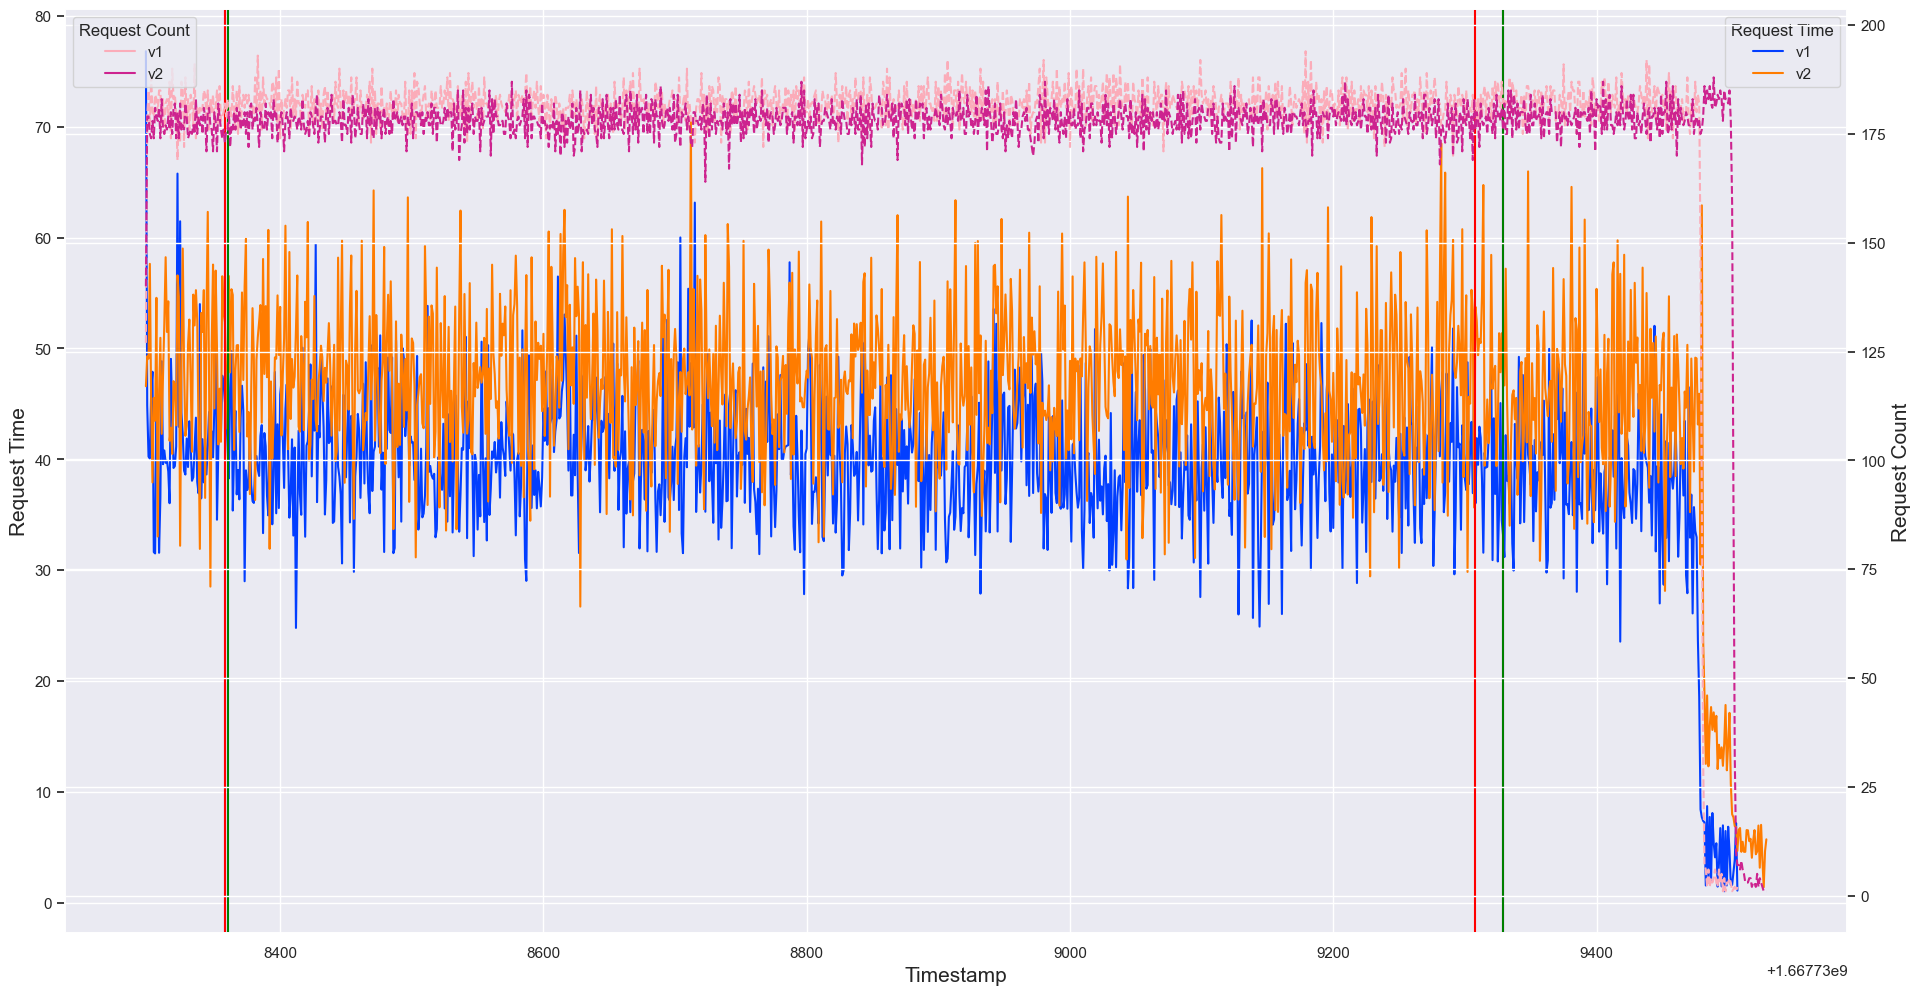

In [34]:

# analyze time drift
# we select the data by iteration to have a equal amount of measurements, but we want to cutoff by time
# this might cause biased results if the drift is too big

df_time_drift = df_filtered.groupby(['version']).agg(timestamp_min=('timestamp', 'min'), timestamp_max=('timestamp', 'max'),).reset_index()
df_time_drift['ts_range'] = df_time_drift['timestamp_max'] - df_time_drift['timestamp_min']
df_time_drift['ts_min_drift'] = df_time_drift['timestamp_min'] - df_time_drift['timestamp_min'].shift(-1)
df_time_drift['ts_max_drift'] = df_time_drift['timestamp_max'] - df_time_drift['timestamp_max'].shift(-1)
df_time_drift['ts_range_drift'] = df_time_drift['ts_range'] - df_time_drift['ts_range'].shift(-1)
print(df_time_drift)


plot_df = df_req_durations.groupby(['timestamp', 'version'])\
  .agg(
    count=('status', 'count'),
    request_duration_median=('metric_value', 'median')
  ).reset_index()

# plot
paletteTime = sns.color_palette("bright", 2)
paletteCount = sns.color_palette("RdPu", 2)

sns.set(rc={'figure.figsize':(23,12)})
g = sns.lineplot(data = plot_df, x='timestamp', y='request_duration_median', hue='version', palette=paletteTime)
g.axvline(maxCutoffTs, color = "magenta")
g.axvline(minCutoffTs, color = "magenta")
g.axvline(df_time_drift.loc[0]['timestamp_min'], color = "red")
g.axvline(df_time_drift.loc[0]['timestamp_max'], color = "red")
g.axvline(df_time_drift.loc[1]['timestamp_min'], color = "green")
g.axvline(df_time_drift.loc[1]['timestamp_max'], color = "green")
g.set_xlabel("Timestamp", fontsize = 15)
g.set_ylabel("Request Time", fontsize = 15)
# g.set_ylim([0, 8500])
g.legend(title="Request Time")
ax2 = g.twinx()
ax2.set_ylabel("Request Count", fontsize = 15)
#ax2.set_ylim([0, 2000])
g2 = sns.lineplot(data = plot_df, x='timestamp', y='count', hue='version', ax=ax2, palette=paletteCount, linestyle="--")
g2.legend(title="Request Count", loc = 'upper left')
g.figure.savefig(f"{benchmarkName}-all-requests.pdf")

/Users/christophwitzko/Dropbox/Cloud/Studium/TUB/master-thesis/master-thesis/analysis/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/christophwitzko/Dropbox/Cloud/Studium/TUB/master-thesis/master-thesis/analysis/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/christophwitzko/Dropbox/Cloud/Studium/TUB/master-thesis/master-thesis/analysis/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/christophwitzko/Dropbox/Cloud/Studium/TUB/master-thesis/master-thesis/analysis/venv/lib/python3.10/sit

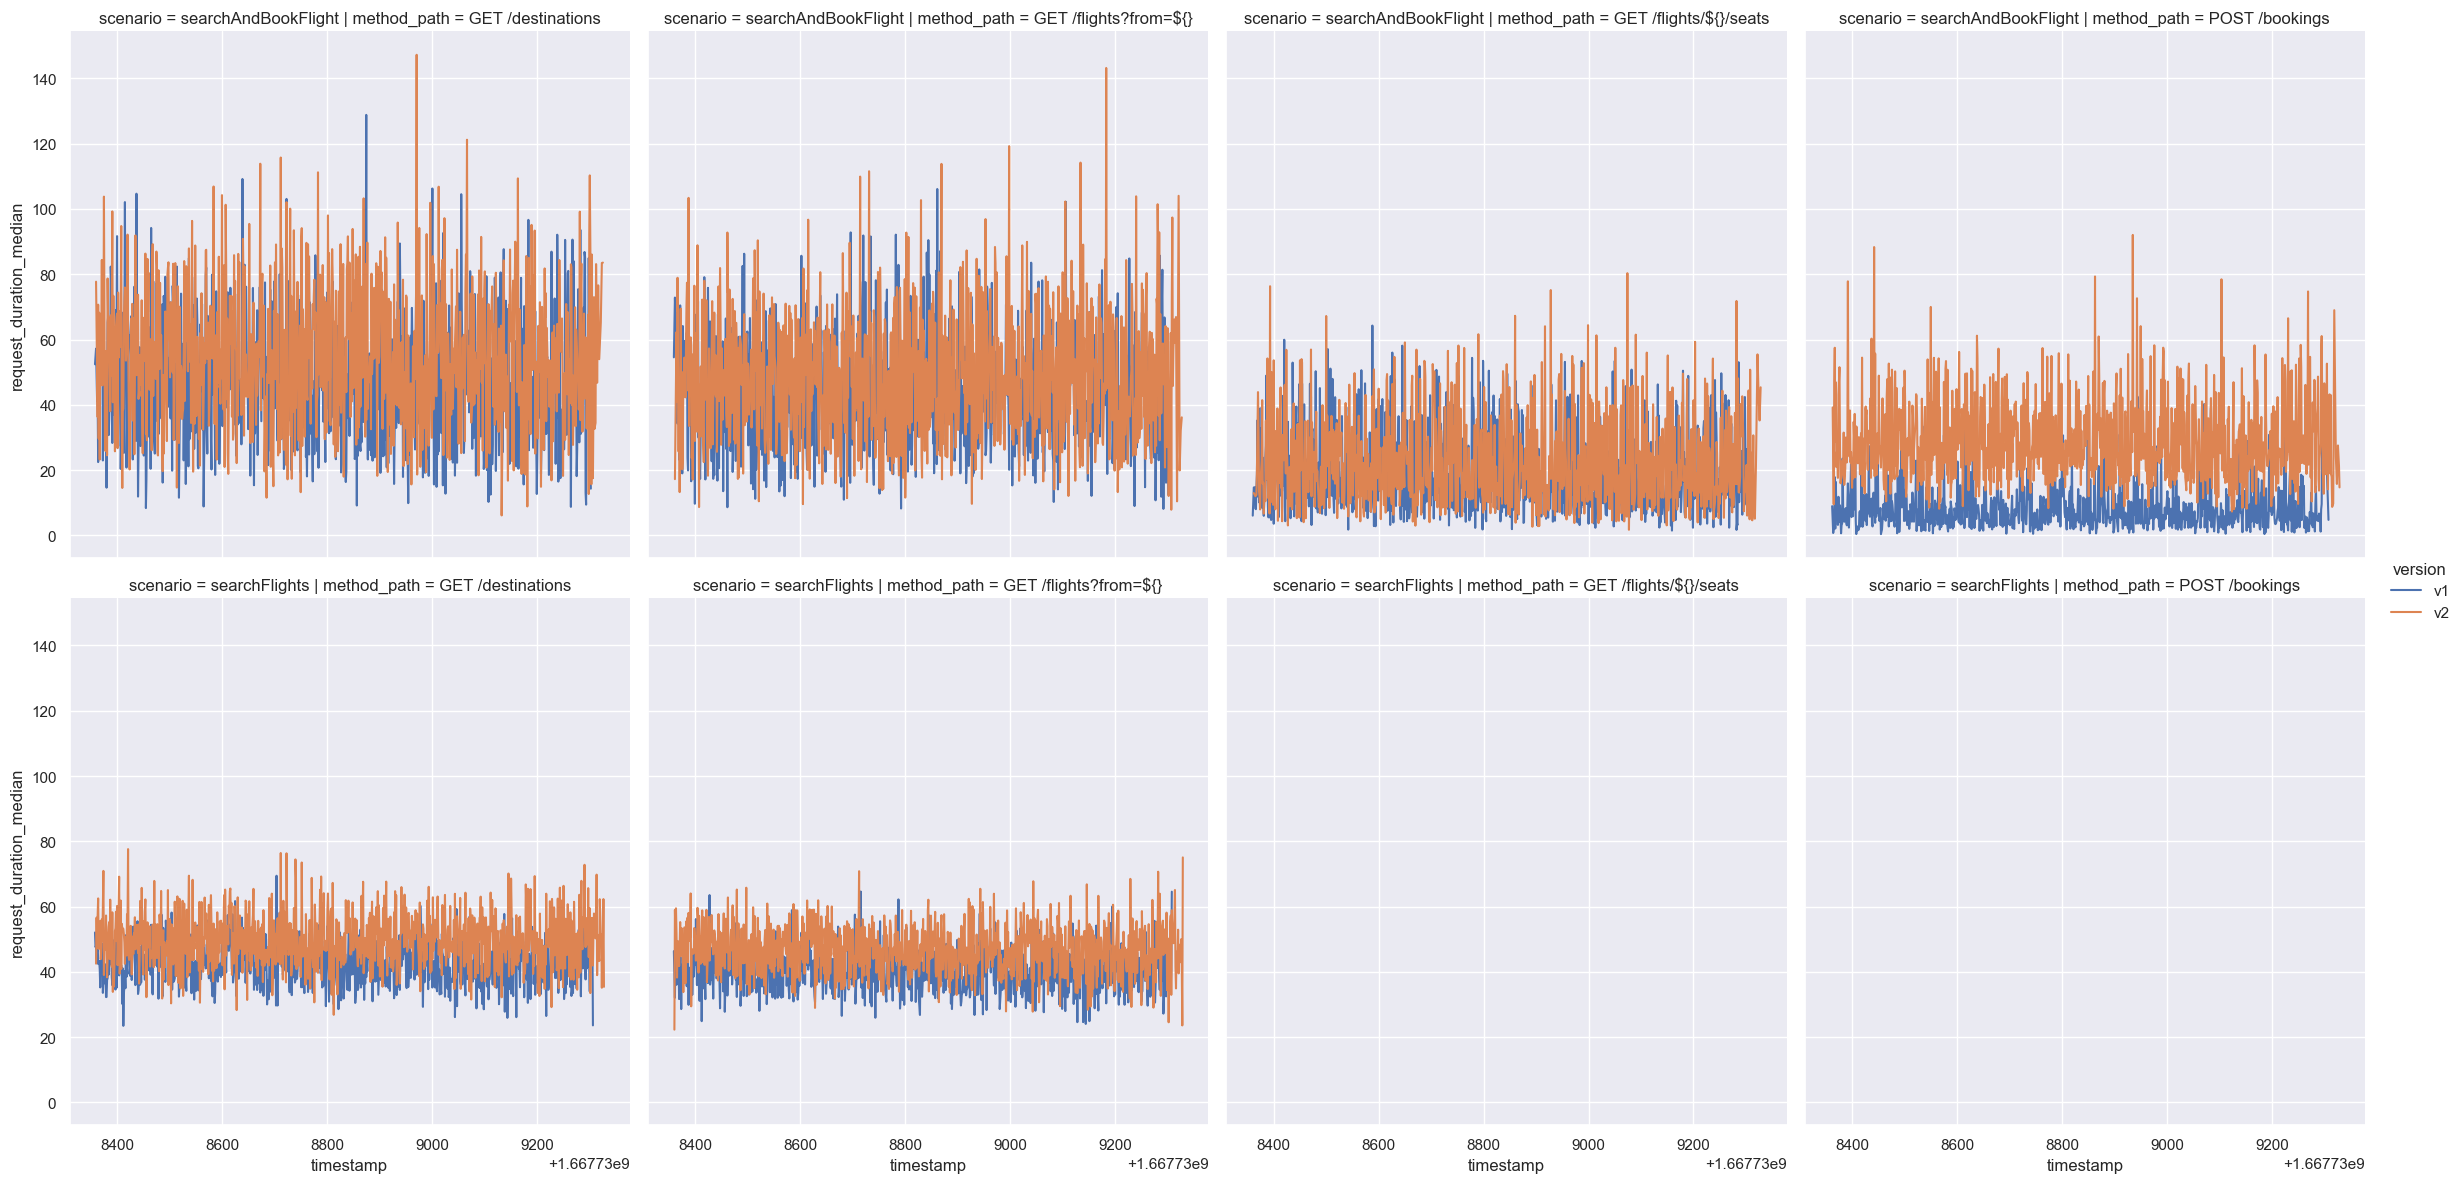

In [35]:
#sns.set(rc={'figure.figsize':(23,12)})

plot_df2 = df_filtered\
  .groupby(['scenario','timestamp', 'method_path', 'version']) .agg(
    count=('status', 'count'),
    request_duration_median=('metric_value', 'median'),
    request_duration_max=('metric_value', 'max'),
    request_duration_min=('metric_value', 'min')
  ).reset_index()
# plot_df2 = plot_df2.melt(id_vars=['scenario', 'iter', 'method_path', 'version'], value_vars=['request_duration_median', 'request_duration_max', 'request_duration_min'])

# plot_df2
# g = sns.lineplot(data = plot_df2, x='timestamp', y='request_duration_median', hue='version', palette=paletteTime)
g = sns.FacetGrid(plot_df2, col="method_path", height=6, row='scenario', hue='version')
g.map(sns.lineplot,  'timestamp', 'request_duration_median')
g.add_legend()
g.savefig(f"{benchmarkName}-requests-by-endpoint.pdf")
g

In [36]:
def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
  allRuntimes1 = perfRuntimes1['metric_value'].to_numpy()
  allRuntimes2 = perfRuntimes2['metric_value'].to_numpy()
  numberOfSamples = 10000
  currentMeasurementIndexes = rng.choice(allRuntimes1.shape[0], size=(allRuntimes1.shape[0], numberOfSamples))
  # Bulk selection
  # print(f"bulk selection v1")
  tmp1 = allRuntimes1[currentMeasurementIndexes]
  # print(f"bulk selection stacking v1")
  tmp1 = np.stack(tmp1, axis=1)
  # print(f"bulk selection v2")
  tmp2 = allRuntimes2[currentMeasurementIndexes]
  # print(f"bulk selection stacking v2")
  tmp2 = np.stack(tmp2, axis=1)

  # Get median for both lists
  # print("calculating medians...")
  med1 = np.median(tmp1, axis=1)
  med2 = np.median(tmp2, axis=1)
  # print("calculating percentual change...")
  R = med2/med1
  # print("sorting...")
  R.sort()

  # print("calculating CI...")
  CIsmall = 1 # 99% confidence interval
  small = int((numberOfSamples * CIsmall) / 100 / 2)
  if small == 0: small = 1
  minSmall = R[small-1]
  minSmall = (minSmall - 1) * 100
  maxSmall = R[numberOfSamples-small-1]
  maxSmall = (maxSmall - 1) * 100
  instability = maxSmall - minSmall
  refData = (R-1) * 100
  return refData, minSmall, maxSmall, instability

In [37]:
def compareVersionsForEndpoint(scenario: str, epName: str):
  runtimes1 = df_filtered[(df_filtered['version'] == 'v1') & (df_filtered['method_path'] == epName) & (df_filtered['scenario'] == scenario)]
  runtimes2 = df_filtered[(df_filtered['version'] == 'v2') & (df_filtered['method_path'] == epName) & (df_filtered['scenario'] == scenario)]
  assert runtimes1.shape[0] == runtimes2.shape[0], "measurements differ between versions"
  # print(f"{runtimes1.shape[0]} values are bootstrapped...")
  median1 = runtimes1['metric_value'].median()
  median2 = runtimes2['metric_value'].median()
  change = ((median2/median1) - 1) * 100
  refData, minci, maxci, instability = bootstrap(runtimes1, runtimes2)
  assert maxci >= change
  assert change >= minci
  name = f"{scenario} - {epName}"
  print(f"[{name}] performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%)")
  return {
    'name': name,
    'scenario': scenario,
    'endpoint': epName,
    'change': change,
    'minci': minci,
    'maxci': maxci,
    'refData': refData
  }


bootstrapResults = []
scenarioNames = df_filtered['scenario'].unique()
scenarioNames.sort()
for scenarioName in scenarioNames:
  endpointNames = df_filtered[df_filtered['scenario'] == scenarioName]['method_path'].unique()
  endpointNames.sort()
  for epName in endpointNames:
    # print(f"starting bootstrap for {scenarioName}/{epName}...")
    bootstrapResults.append(compareVersionsForEndpoint(scenarioName, epName))

bootstrapResults_df = pd.DataFrame(bootstrapResults)
bootstrapResults_df

[searchAndBookFlight - GET /destinations] performance change: 21.56% [14.28 - 27.51] (13.23%)
[searchAndBookFlight - GET /flights/${}/seats] performance change: 20.03% [11.03 - 30.79] (19.76%)
[searchAndBookFlight - GET /flights?from=${}] performance change: 10.88% [4.04 - 16.46] (12.42%)
[searchAndBookFlight - POST /bookings] performance change: 333.17% [299.98 - 368.41] (68.43%)
[searchFlights - GET /destinations] performance change: 16.50% [15.13 - 18.04] (2.91%)
[searchFlights - GET /flights?from=${}] performance change: 16.33% [14.99 - 17.63] (2.65%)


,name,scenario,endpoint,change,minci,maxci,refData
0,searchAndBookFlight - GET /destinations,searchAndBookFlight,GET /destinations,21.561023,14.281310,27.512585,"[10.042684899919085, 10.414133719558215, 11.63..."
1,searchAndBookFlight - GET /flights/${}/seats,searchAndBookFlight,GET /flights/${}/seats,20.031740,11.033018,30.793378,"[6.482142996556317, 8.526753261488995, 8.57816..."
2,searchAndBookFlight - GET /flights?from=${},searchAndBookFlight,GET /flights?from=${},10.878272,4.036849,16.460153,"[1.3367864586596667, 1.7980983359069391, 1.960..."
3,searchAndBookFlight - POST /bookings,searchAndBookFlight,POST /bookings,333.168156,299.982474,368.408367,"[290.011242117477, 291.2154117492085, 291.5752..."
4,searchFlights - GET /destinations,searchFlights,GET /destinations,16.503516,15.130380,18.039006,"[14.18213013601115, 14.4526568132342, 14.53154..."
5,searchFlights - GET /flights?from=${},searchFlights,GET /flights?from=${},16.326139,14.988078,17.634736,"[14.178961519976752, 14.467917475694293, 14.48..."


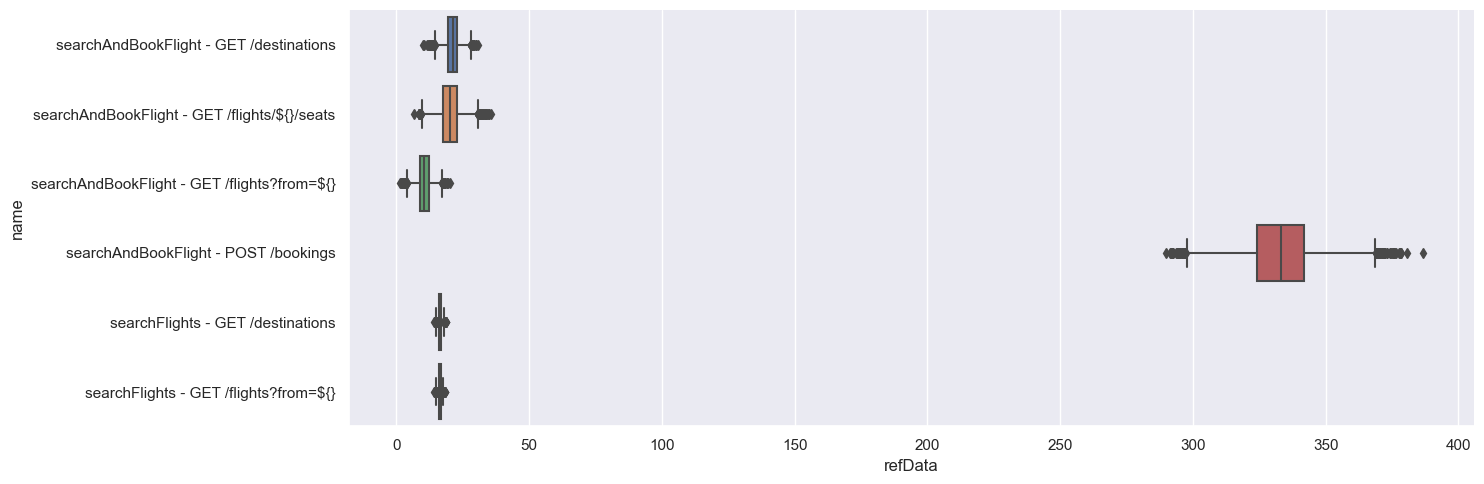

In [38]:
boxPlotDf = bootstrapResults_df.explode('refData')
# g = sns.FacetGrid(boxPlotDf, col="endpoint", height=6, row='scenario')
# g.map(sns.pointplot,  'refData', errorbar= errorbar)
# g.add_legend()
g = sns.catplot(data=boxPlotDf, x="refData", y="name", kind="box", aspect=3)
g.savefig(f"{benchmarkName}-perf-change.pdf")